# Part A - Text categorization

We will use president speeches to categorize them.

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [1]:
import os

from os import walk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import plotly.express as px

import nltk

## 1. Data cleaning

In [2]:
president_speech = pd.DataFrame(columns=['date','subject','speech_length','speech','label'])

path = 'presidents-speeches/'

for (root, dirs, files) in walk(path):
    for file in files:
        # We make sure that we take only speeche files
        if file.endswith(".txt") and not(file.startswith("initial")):
            president = root.split('/')[1]
            date = file.split('_')[0]
            date = datetime.strptime(date, '%B %d, %Y')
            subject = file.split('_')[2].split('.')[0]
            with open(os.path.join(root,file)) as f:
                speech = f.read()
                current_president_speech = pd.DataFrame({
                    'date': [date],
                    'subject' :[subject],
                    'speech_length' : [len(speech.split(' '))],
                    'speech': [speech],
                    'label': [president]
                })
                president_speech = president_speech.append(current_president_speech, ignore_index=True)

In [3]:
president_speech

date                                            subject  \
0   1796-03-30  MessagetotheHouseofRepresentativesDecliningtoS...   
1   1795-12-08                     SeventhAnnualMessagetoCongress   
2   1796-12-07                      EighthAnnualMessagetoCongress   
3   1794-08-07  ProclamationagainstOppositiontoExecutionofLaws...   
4   1794-11-19                       SixthAnnualMessagetoCongress   
..         ...                                                ...   
371 1974-08-09                RemarksonDepartureFromtheWhiteHouse   
372 1974-02-25                        ThePresidentsNewsConference   
373 1970-04-30    AddresstotheNationontheSituationinSoutheastAsia   
374 1973-04-30  AddresstotheNationAbouttheWatergateInvestigations   
375 1969-11-03                AddresstotheNationontheWarinVietnam   

    speech_length                                             speech  \
0            1245  b' Gentlemen of the House of Representatives: ...   
1            1953  b'I trust I do not deceive myself when I indul...   
2            3339  b" Fellow Citizens of the Senate and House of ...   
3            1285  b'Whereas combinations to defeat the execution...   
4            3387  b' Fellow Citizens of the Senate and of the Ho...   
..            ...                                                ...   
371          1766  b'Members of the Cabinet, members of the White...   
372          5259  b'The President: Ladies and gentlemen, before ...   
373          2641  b"Good evening my fellow Americans:\r\nTen day...   
374          2677  b'Good evening:\r\nI want to talk to you tonig...   
375          4397  b'Good evening, my fellow Americans:\n\r\nToni...   

                 label  
0    George Washington  
1    George Washington  
2    George Washington  
3    George Washington  
4    George Washington  
..                 ...  
371   Richard M. Nixon  
372   Richard M. Nixon  
373   Richard M. Nixon  
374   Richard M. Nixon  
375   Richard M. Nixon  

[376 rows x 5 columns]

## 2. Data visualisation

### 2.1 Distribution of Presidents speeches

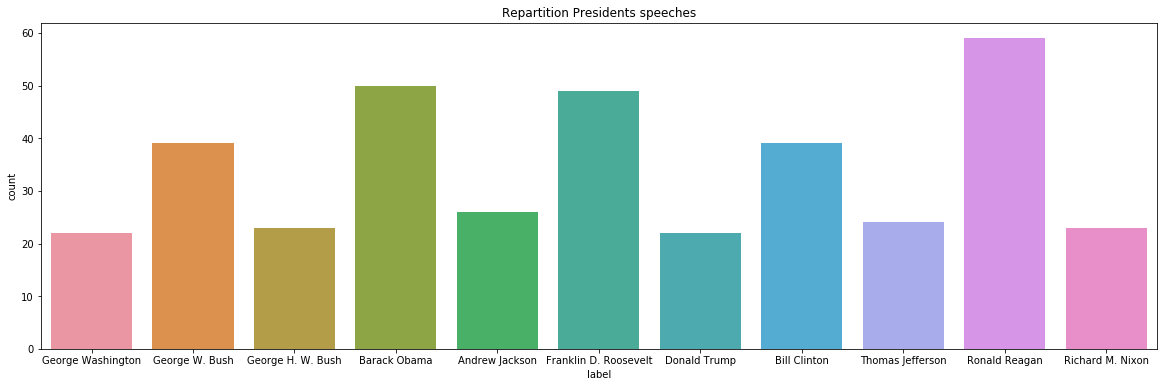

In [4]:
plt.figure(figsize=(20,6))
sns.countplot(x = 'label',data = president_speech)
plt.title("Repartition Presidents speeches")
plt.show()

In [5]:
president_pie = president_speech.groupby('label').size()/president_speech['label'].count()*100
labels = president_pie.index
values = president_pie.values
fig_president = px.pie(labels=labels, values=values, names=labels, hole=.5)

fig_president.update_layout(
    title_text="Repartition of President speeches in the dataset")
    # Add annotations in the center of the donut pies.

fig_president.show()

### 2.2 Length of President speeches

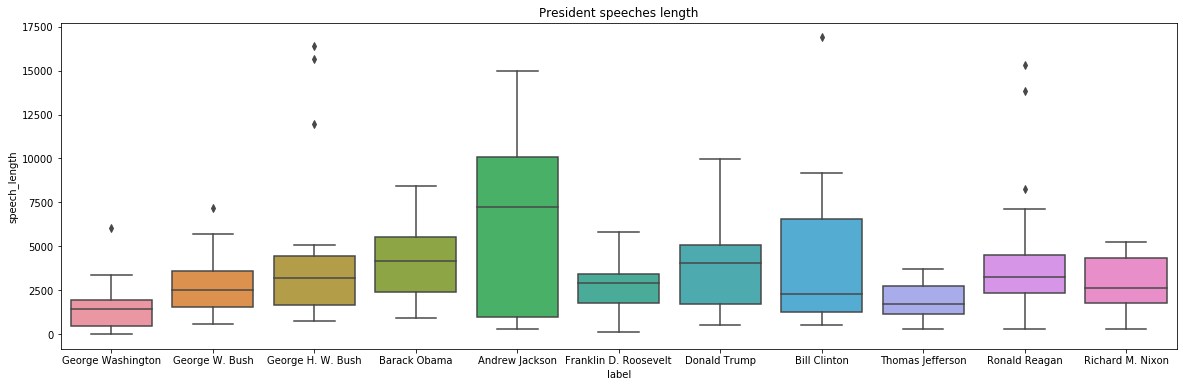

In [6]:
plt.figure(figsize=(20,6))
sns.boxplot(data=president_speech, x='label', y='speech_length')
plt.title("President speeches length");

### 2.3 Distribution of Presidents speeches through years

In [7]:
fig = px.histogram(president_speech, x='date', y='label', color='label')
fig.show()

## 3. Pre-processing

In [8]:
president_speech['speech'] = [word_tokenize(entry.lower()) for entry in president_speech['speech'].dropna()]

In [9]:
tag_map = defaultdict(lambda:wn.NOUN)
tag_map['J']= wn.ADJ
tag_map['V']= wn.VERB
tag_map['R']= wn.ADV

stopWords = stopwords.words('english')

word_Lemmatized = WordNetLemmatizer()

for index,entry in enumerate(president_speech['speech']):
    final_words = []
    
    for word, tag in pos_tag(entry):
        #below condition is to check for top words and consider only alphabets
        if word not in stopWords and word.isalpha():
            final_words.append(word_Lemmatized.lemmatize(word,tag_map[tag[0]]))
    #The final processed set of WORD FOR EACH ITERATION WILL be stored in 'text_final'
    president_speech.loc[index,'text_final']= str(final_words)

In [10]:
inputs = president_speech['text_final']
output = president_speech['label']

In [11]:
# split your data into training and testing sets
train_x, test_x, train_y, test_y = model_selection.train_test_split(inputs, 
                                                                    output, 
                                                                    test_size=0.2)

In [12]:
#label encoding
encoder = LabelEncoder()
train_y_encoded = encoder.fit_transform(train_y)
test_y_encoded = encoder.fit_transform(test_y)

## 4. Feature engineering

### 4.1 TF/IDF 

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

a. **Word Level TF-IDF** : Matrix representing tf-idf scores of every term in different documents  
b. **N-gram Level TF-IDF** : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams  
c. **Character Level TF-IDF** : Matrix representing tf-idf scores of character level n-grams in the corpus  

In [13]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(inputs)
train_x_tfidf =  tfidf_vect.transform(train_x)
test_x_tfidf =  tfidf_vect.transform(test_x)

In [14]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(president_speech['text_final'])
train_x_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
test_x_tfidf_ngram =  tfidf_vect_ngram.transform(test_x)

In [15]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(president_speech['text_final'])
train_x_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
test_x_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_x)

### 4.2 Count Vectorizer

Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

In [16]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(inputs)

# transform the training and validation data using count vectorizer object
train_x_count =  count_vect.transform(train_x)
test_x_count =  count_vect.transform(test_x)

## 5. Model prediction

In [17]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return accuracy_score(predictions, test_y_encoded)*100

### 5.1 Naives Bayes

Implementing a naive bayes model using sklearn implementation with different features

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors.

In [18]:
# Naive Bayes on Count Vectors
NB = naive_bayes.MultinomialNB()
accuracy_NB_count = train_model(NB, train_x_count, train_y_encoded, test_x_count)
print("NB, Count Vectors: ", accuracy_NB_count)

NB, Count Vectors:  67.10526315789474


In [19]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy_NB_tfidf = train_model(naive_bayes.MultinomialNB(), train_x_tfidf, train_y_encoded, test_x_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy_NB_tfidf)

NB, WordLevel TF-IDF:  44.73684210526316


In [20]:
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_NB_ngram = train_model(naive_bayes.MultinomialNB(), train_x_tfidf_ngram, train_y_encoded, test_x_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy_NB_ngram)

NB, N-Gram Vectors:  51.31578947368421


In [21]:
# Naive Bayes on Character Level TF IDF Vectors
accuracy_NB_char = train_model(naive_bayes.MultinomialNB(), train_x_tfidf_ngram_chars, train_y_encoded, test_x_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy_NB_char)

NB, CharLevel Vectors:  51.31578947368421


### 5.2 Logistic Regression

Implementing a Linear Classifier (Logistic Regression)

Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. 

In [22]:
# Logistic Regression on Count Vectors
LR_count = linear_model.LogisticRegression()
accuracy_LR_count = train_model(LR_count, train_x_count, train_y_encoded, test_x_count)
print("LR, Count Vectors: ", accuracy_LR_count)

LR, Count Vectors:  78.94736842105263


/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [23]:
# Logistic Regression Level TF IDF Vectors
LR_tfidf = linear_model.LogisticRegression()
accuracy_LR_tfidf = train_model(LR_tfidf, train_x_tfidf, train_y_encoded, test_x_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy_LR_tfidf)

LR, WordLevel TF-IDF:  71.05263157894737


In [24]:
# Logistic Regression on Ngram Level TF IDF Vectors
accuracy_LR_ngram = train_model(linear_model.LogisticRegression(), train_x_tfidf_ngram, train_y_encoded, test_x_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy_LR_ngram)

LR, N-Gram Vectors:  59.210526315789465


In [25]:
# Logistic Regression on Character Level TF IDF Vectors
accuracy_LR_chars = train_model(linear_model.LogisticRegression(), train_x_tfidf_ngram_chars, train_y_encoded, test_x_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy_LR_chars)

LR, CharLevel Vectors:  59.210526315789465


### 5.3 SVM

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges.

In [26]:
# SVM on on Count Vectors
accuracy_SVM_count = train_model(svm.SVC(), train_x_count, train_y_encoded, test_x_count)
print("SVM, Count Vectors: ", accuracy_SVM_count)

SVM, Count Vectors:  51.31578947368421


In [27]:
# SVM on Level TF IDF Vectors
accuracy_SVM_tfidf = train_model(svm.SVC(), train_x_tfidf, train_y_encoded, test_x_tfidf)
print("SVM, WordLevel TF-IDF: ", accuracy_SVM_tfidf)

SVM, WordLevel TF-IDF:  71.05263157894737


In [28]:
# SVM on Ngram Level TF IDF Vectors
accuracy_SVM_ngram = train_model(svm.SVC(), train_x_tfidf_ngram, train_y_encoded, test_x_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy_SVM_ngram)

SVM, N-Gram Vectors:  47.368421052631575


In [29]:
# SVM on Character Level TF IDF Vectors
accuracy_SVM_chars = train_model(svm.SVC(), train_x_tfidf_ngram_chars, train_y_encoded, test_x_tfidf_ngram_chars)
print("SVM, CharLevel Vectors: ", accuracy_SVM_chars)

SVM, CharLevel Vectors:  47.368421052631575


## 6. Save model and train it

We display the accuracy of each model into a dataframe.  
Then, we try to see how accurate our models are.

In [30]:
accuracies = {'model': ['NB, Count Vectors',
                        'NB, WordLevel TF-IDF Vectors',
                        'NB, N-Gram Vectors',
                        'NB, CharLevel Vectors',
                        'LR, Count Vectors',
                        'LR, WordLevel TF-IDF Vectors',
                        'LR, N-Gram Vectors',
                        'LR, CharLevel Vectors',
                        'SVM, Count Vectors',
                        'SVM, WordLevel TF-IDF Vectors',
                        'SVM, N-Gram Vectors',
                        'SVM, CharLevel Vectors'], 
              'accuracy': [accuracy_NB_count,
                       accuracy_NB_tfidf,
                       accuracy_NB_ngram,
                       accuracy_NB_char,
                       accuracy_LR_count,
                       accuracy_LR_tfidf,
                       accuracy_LR_ngram,
                       accuracy_LR_chars,
                       accuracy_SVM_count,
                       accuracy_SVM_tfidf,
                       accuracy_SVM_ngram,
                       accuracy_SVM_chars]}

models = pd.DataFrame(accuracies)
models.set_index('model', inplace=True)
models.sort_values('accuracy', ascending = False)

accuracy
model                                   
LR, Count Vectors              78.947368
LR, WordLevel TF-IDF Vectors   71.052632
SVM, WordLevel TF-IDF Vectors  71.052632
NB, Count Vectors              67.105263
LR, N-Gram Vectors             59.210526
LR, CharLevel Vectors          59.210526
NB, N-Gram Vectors             51.315789
NB, CharLevel Vectors          51.315789
SVM, Count Vectors             51.315789
SVM, N-Gram Vectors            47.368421
SVM, CharLevel Vectors         47.368421
NB, WordLevel TF-IDF Vectors   44.736842

In [31]:
# LR Count
som = 0
for i in range(0,len(test_y)):

    sentence_to_classify = test_x.iloc[i]
    actual_president = test_y.iloc[i]
    LR_count.fit(train_x_count, train_y_encoded)
    predicted_president = president_speech.label.unique()[LR_count.predict(count_vect.transform([sentence_to_classify]))[0]]

    if actual_president==predicted_president:
        som+=1
        print('Actual president :', actual_president, '\n')
        
print('Number of good prediction on the test set :',som, 'on', len(test_y))

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : George Washington 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Actual president : George W. Bush 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : George Washington 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/romane/op

Actual president : Ronald Reagan 



/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Number of good prediction on the test set : 15 on 76


/Users/romane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [32]:
# LR TFIDF
som = 0
for i in range(0,len(test_y)):

    sentence_to_classify = test_x.iloc[i]
    actual_president = test_y.iloc[i]
    LR_tfidf.fit(train_x_tfidf, train_y_encoded)
    predicted_president = president_speech.label.unique()[LR_tfidf.predict(tfidf_vect.transform([sentence_to_classify]))[0]]

    if actual_president==predicted_president:
        som+=1
        print('Actual president :', actual_president, '\n')

print('Number of good prediction on the test set :',som, 'on', len(test_y))

Actual president : George Washington 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : George W. Bush 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : George W. Bush 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : George Washington 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : George W. Bush 

Actual president : Ronald Reagan 

Number of good prediction on the test set : 18 on 76


In [33]:
# NB COUNT
som = 0
for i in range(0,76):

    sentence_to_classify = test_x.iloc[i]
    actual_president = test_y.iloc[i]
    NB.fit(train_x_count, train_y_encoded)
    predicted_president = president_speech.label.unique()[NB.predict(count_vect.transform([sentence_to_classify]))[0]]

    if actual_president==predicted_president:
        som+=1
        print('Actual president :', actual_president, '\n')

print('Number of good prediction on the test set :',som, 'on', len(test_y))

Actual president : George Washington 

Actual president : George Washington 

Actual president : George H. W. Bush 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : George W. Bush 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : George W. Bush 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : George Washington 

Actual president : Ronald Reagan 

Actual president : Ronald Reagan 

Actual president : George W. Bush 

Actual president : George Washington 

Actual president : George Washington 

Actual president : Ronald Reagan 

Number of good prediction on the test set : 22 on 76
